In [1]:
import matplotlib.pyplot as plt

from src.surface import *
from src.view_profile import *
from src.site import *
from src.array import SurfaceArray

In [2]:
# Building Constants
latitude = -27.48637226
longitude = 153.01796166
tz = 'Australia/Brisbane'


# Building site
# site = Site(latitude=latitude, longitude=longitude, tz=tz)
site = Site(latitude=latitude, longitude=longitude, tz=tz,
            tmy_path='src/torbreck/tmy_2005_2023.epw')

/workspace/src/site.py:52: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  tmy.index = tmy.index + pd.DateOffset(year=2013)


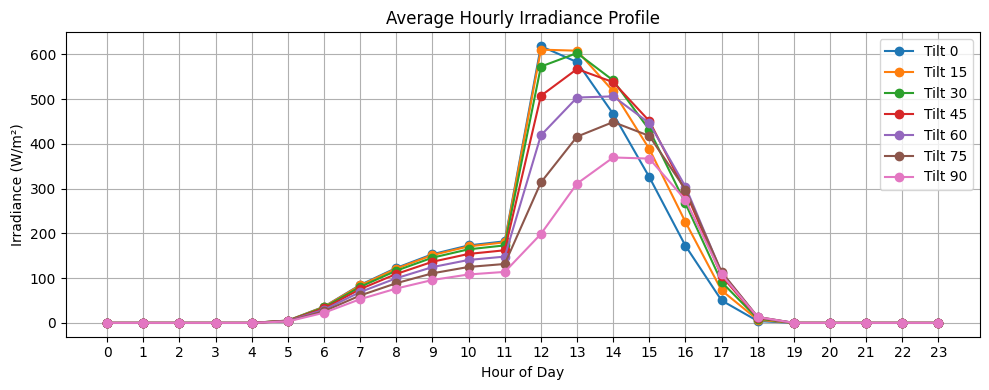

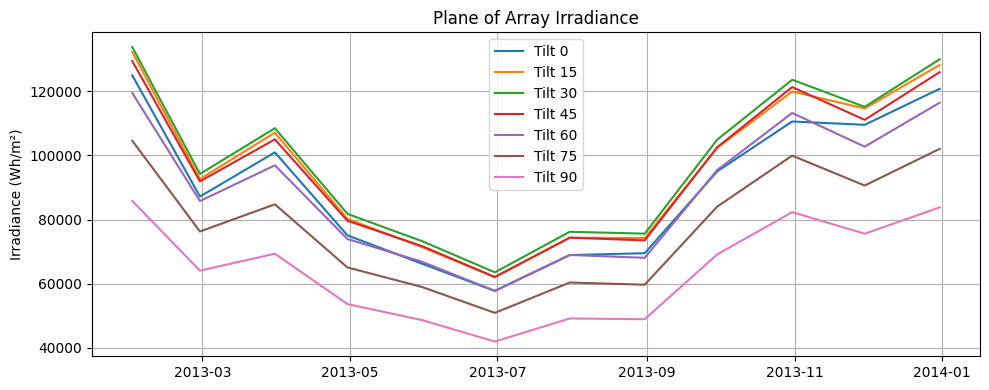

In [3]:
orientation_azimuth = 270

solar_position, site_irradiance = site.get_solar()

fig1, ax1 = plt.subplots(figsize=(10, 4))
fig2, ax2 = plt.subplots(figsize=(10, 4))
for x in range(0, 91, 15):
    surface = Surface('test', SurfaceType.BALCONY, orientation_azimuth, site, 0, view_profile=BACKED,
                      tilt=x)  # e.g., west-facing in Brisbane
    irradiance_results = surface.solve_irradiance(
        solar_position, site_irradiance)
    irradiance_results.plot_daily_profile(
        figure=fig1, show=False, label=f'Tilt {x}')
    irradiance_results.plot_total_irradiance(
        figure=fig2, show=False, label=f'Tilt {x}', sample='ME')

fig1.show()
fig2.show()

### Generate East and West Surfaces and plot Surface Profile

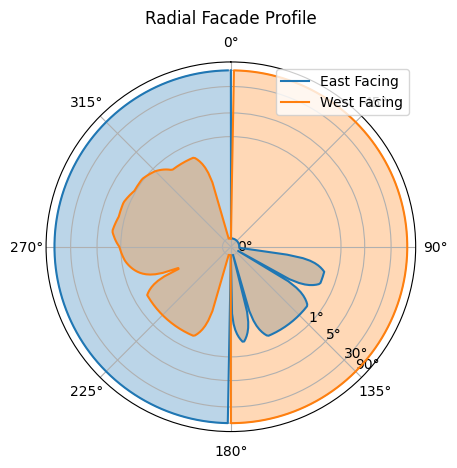

<PolarAxes: title={'center': 'Radial Facade Profile'}>

In [4]:
Surface_W = Surface('West Surface', SurfaceType.FACADE, 270, site, 10, view_profile=BACKED,
                    tilt=90)  # e.g., west-facing in Brisbane
Surface_E = Surface('East Surface', SurfaceType.FACADE, 90, site, 10, view_profile=BACKED,
                    tilt=90)

# Radial Surface Profile of East and West facing Surfaces
ax = Surface_E.view_profile.plot_radial(label='East Facing', show=False)
Surface_W.view_profile.plot_radial(ax=ax, label='West Facing')

## Simulate Surface as a PV array

In [5]:
# Test of PV modules simulation
array_kwargs = dict(
    module_parameters=dict(pdc0=1, gamma_pdc=-0.004),
    temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)
)

arrays = [
    SurfaceArray(pvsystem.FixedMount(90, 270),
                 name='West-Facing Array', Surface_profile=Surface_W.Surface_profile, **array_kwargs),
    SurfaceArray(pvsystem.FixedMount(90, 90),
                 name='East-Facing Array', Surface_profile=Surface_E.Surface_profile, **array_kwargs),
]


system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=3))
mc = modelchain.ModelChain(system, site.location, aoi_model='physical',
                           spectral_model='no_loss')


mc.run_model(site.tmy)

fig, ax = plt.subplots()
for array, pdc in zip(system.arrays, mc.results.dc):
    pdc.groupby(
        pdc.index.time
    ).mean().plot(label=f'{array.name}')

inverter = mc.results.ac
inverter.groupby(inverter.index.time).mean().plot(label='Inverter')
plt.ylabel('System Output')
plt.legend()
plt.show()

NameError: name 'pvsystem' is not defined